In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


samsung = pd.read_csv('krx/stocks/삼성전자.csv')
samsung['Date'] = pd.to_datetime(samsung['Date'])  # 날짜 형식으로 변환

In [2]:
samsung.dropna(inplace=True)

In [3]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5999 entries, 1 to 5999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5999 non-null   datetime64[ns]
 1   Open    5999 non-null   int64         
 2   High    5999 non-null   int64         
 3   Low     5999 non-null   int64         
 4   Close   5999 non-null   int64         
 5   Volume  5999 non-null   int64         
 6   Change  5999 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 374.9 KB


### 코사인 유사도

In [8]:
import warnings
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

In [10]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5999 entries, 1 to 5999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5999 non-null   datetime64[ns]
 1   Open    5999 non-null   int64         
 2   High    5999 non-null   int64         
 3   Low     5999 non-null   int64         
 4   Close   5999 non-null   int64         
 5   Volume  5999 non-null   int64         
 6   Change  5999 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 374.9 KB


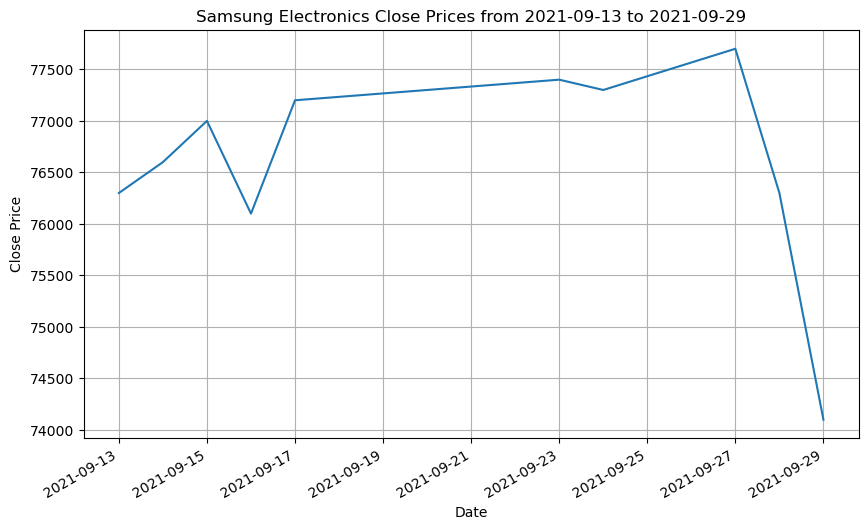

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 로드 및 인덱스 변환
samsung_data_index = pd.read_csv('krx/stocks/삼성전자.csv', index_col='Date', parse_dates=True)
samsung_data_index.dropna(inplace=True)
# 종가 추출
close = samsung_data_index['Close']

# 비교 기준 구간
start_date = '2021-09-13'
end_date = '2021-09-29'

# 기준 구간 시계열 차트
plt.figure(figsize=(10, 6))
close[start_date:end_date].plot()
plt.title(f'Samsung Electronics Close Prices from {start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


In [32]:
base = close[start_date:end_date]
base

Date
2021-09-13    76300
2021-09-14    76600
2021-09-15    77000
2021-09-16    76100
2021-09-17    77200
2021-09-23    77400
2021-09-24    77300
2021-09-27    77700
2021-09-28    76300
2021-09-29    74100
Name: Close, dtype: int64

In [34]:
# 정규화 날짜를  0과1 사이로 정규화함
base_norm = (base - base.min()) / (base.max() - base.min())
base_norm

Date
2021-09-13    0.611111
2021-09-14    0.694444
2021-09-15    0.805556
2021-09-16    0.555556
2021-09-17    0.861111
2021-09-23    0.916667
2021-09-24    0.888889
2021-09-27    1.000000
2021-09-28    0.611111
2021-09-29    0.000000
Name: Close, dtype: float64

In [38]:
# 윈도우 사이즈 (몇일간의 패턴을 볼지 선택) 15일간
window_size = len(base)

# 예측 기간 , 주말은 쉬기에? 5일만 예측
next_date = 5

# 검색 횟수
# 전체 길이에서 - 윈도우 사이즈만큼 빼고 - 예측기간 

moving_cnt = len(close) - window_size - next_date - 1

# 정리 - 윈도우 사이즈 12개
#     - 16개씩 계속 반폭하면서 패턴 검출

In [40]:
from scipy.spatial.distance import cosine
# 시계열 차트의 패턴과 원본 데이터의 순회하는 패턴 사이에서 코사인 유사도 계산
# 코사인 유사도 1의 가까울수록 유사도가 높다.
# 유사도 저장 딕셔너리

# 유사도 저장 리스트
sim_list = []

for i in range(moving_cnt):
    target = close[i:i+window_size]
    
    # 정규화
    target_norm = (target - target.min()) / (target.max() - target.min())
    
    # 코사인 유사도 계산
    cos_similarity = 1 - cosine(base_norm, target_norm)
    
    # 유사도 및 인덱스 저장
    sim_list.append((i, cos_similarity))

# 결과를 DataFrame으로 변환
sim_df = pd.DataFrame(sim_list, columns=['Index', 'Cosine_Similarity'])

# 정규화된 데이터와 기준이되는 데이터 사이에서 코사인 유사도 계산

In [42]:

# 유사도 상위 20개 선택
top_similarities = sim_df.sort_values(by='Cosine_Similarity', ascending=False).head(20)

top_similarities

,Index,Cosine_Similarity
5279,5279,1.000000
991,991,0.991430
1521,1521,0.991328
3553,3553,0.986162
74,74,0.985475
280,280,0.984910
5006,5006,0.984474
3174,3174,0.983513
4040,4040,0.982304
5184,5184,0.980896


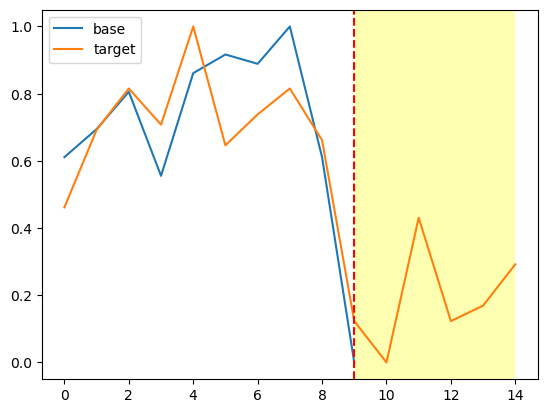

In [54]:
# base가 기준이 되는 패턴
# target이 찾아낸 패턴
# 유사도 계산은 빨간색 점선까지 이후 실질적으로 찾은 패턴이
# 향후 5일 동안 어땠는지 보여줌

# 유사도 기준으로 0.98 이상이면 유사하다고 판단 완전 일치는 아니지만 거의 유사

idx = 3203

top_ = close[idx:idx+window_size+next_date]
top_norm = (top_ - top_.min()) / (top_.max() - top_.min())

plt.plot(base_norm.values, label='base')
plt.plot(top_norm.values, label='target')
plt.axvline(x=len(base_norm)-1, c='r', linestyle='--')
plt.axvspan(len(base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
plt.legend()
plt.show()

In [12]:
class PatternFinder():
    def __init__(self, period=5):
        self.period = period
    
    def set_stock(self, code: str):
        self.code = code
        self.data = fdr.DataReader(code)
        self.close = self.data['Close']
        self.change = self.data['Change']
        return self.data
        
    def search(self, start_date, end_date, threshold=0.98):
        base = self.close[start_date:end_date]
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base
        
        display(base)
        
        window_size = len(base)
        moving_cnt = len(self.data) - window_size - self.period - 1
        cos_sims = self.__cosine_sims(moving_cnt, window_size)
        
        self.window_size = window_size
        cos_sims = cos_sims[cos_sims > threshold]
        return cos_sims
    
    
    def __cosine_sims(self, moving_cnt, window_size):
        def cosine_similarity(x, y):
            return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        
        # 유사도 저장 딕셔너리
        sim_list = []

        for i in range(moving_cnt):
            target = self.close[i:i+window_size]

            # Normalize
            target_norm = (target - target.min()) / (target.max() - target.min())

            # 코사인 유사도 저장
            cos_similarity = cosine_similarity(self.base_norm, target_norm)

            # 코사인 유사도 <- i(인덱스), 시계열데이터 함께 저장
            sim_list.append(cos_similarity)
        return pd.Series(sim_list).sort_values(ascending=False)

    
    def plot_pattern(self, idx, period=5):
        if period != self.period:
            self.period = period
            
        top = self.close[idx:idx+self.window_size+period]
        top_norm = (top - top.min()) / (top.max() - top.min())

        plt.plot(self.base_norm.values, label='base')
        plt.plot(top_norm.values, label='target')
        plt.axvline(x=len(self.base_norm)-1, c='r', linestyle='--')
        plt.axvspan(len(self.base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
        plt.legend()
        plt.show()
        
        
        preds = self.change[idx+self.window_size: idx+self.window_size+period]
        display(preds)
        print(f'pred: {preds.mean()*100} % ')

    
    def stat_prediction(self, result, period=5):
        idx_list = list(result.keys())
        mean_list = []
        for idx in idx_list:
            pred = self.change[idx+self.window_size: idx+self.window_size+period]
            mean_list.append(pred.mean())
        return np.array(mean_list)

In [13]:
p = PatternFinder()

In [14]:
# 삼성전자
p.set_stock('005930')

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-05-02,6200,6530,6120,6280,1446713,NaN
2000-05-03,6240,6260,6090,6180,531786,-0.015924
2000-05-04,6220,6360,6140,6180,522021,0.000000
2000-05-08,6400,6700,6300,6560,1053944,0.061489
2000-05-09,6500,6540,6340,6370,1010990,-0.028963
...,...,...,...,...,...,...
2024-08-13,76500,76600,75500,76100,10716261,0.007947
2024-08-14,77400,77800,77000,77200,13246168,0.014455
2024-08-16,79400,80200,78700,80200,22061478,0.038860


In [15]:
result = p.search('2021-09-10', '2021-09-30')

Date
2021-09-10    75300
2021-09-13    76300
2021-09-14    76600
2021-09-15    77000
2021-09-16    76100
2021-09-17    77200
2021-09-23    77400
2021-09-24    77300
2021-09-27    77700
2021-09-28    76300
2021-09-29    74100
2021-09-30    74100
Name: Close, dtype: int64

In [16]:
result

5277    1.000000
5004    0.982496
989     0.981872
dtype: float64

In [17]:
pred = p.stat_prediction(result)
pred

array([-0.00709228, -0.00177122, -0.01865336])

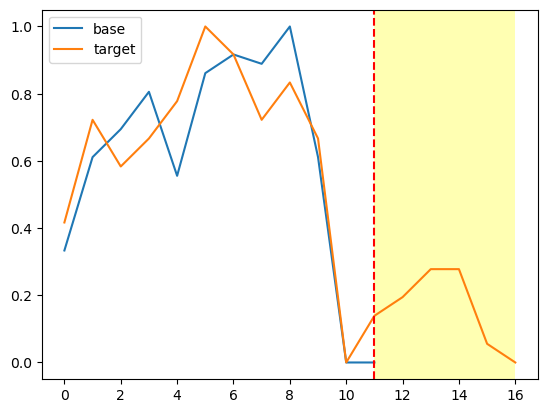

Date
2020-08-24    0.003578
2020-08-25    0.005348
2020-08-26    0.000000
2020-08-27   -0.014184
2020-08-28   -0.003597
Name: Change, dtype: float64

pred: -0.1771221670217038 % 


In [18]:
p.plot_pattern(5004)

In [19]:
# pred: -0.1771221670217038  향후 수익률

### 분류
- create_labeled_data 메서드:

- 코사인 유사도를 특징(feature)으로 사용하고, 주가가 상승했는지 하락했는지를 기반으로 레이블(label)을 생성합니다.
- classify_patterns 메서드:

- 생성된 특징과 레이블 데이터를 사용해 분류 모델을 학습하고, 테스트 데이터를 평가합니다.
- 이 예제에서는 RandomForestClassifier를 사용해 주가가 상승할지 하락할지를 예측합니다.

- 모델 평가: 모델의 정확도, 정밀도, 재현율 등을 확인하여 성능을 평가합니다.

- 모델링 적용 모르겠음

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

class PatternFinder:
    def __init__(self, period=5):
        self.period = period
    
    def set_stock(self, code: str):
        self.code = code
        self.data = fdr.DataReader(code)
        self.close = self.data['Close']
        self.change = self.data['Change']
        return self.data
        
    def search(self, start_date, end_date, threshold=0.98):
        base = self.close[start_date:end_date]
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base
        
        display(base)
        
        window_size = len(base)
        moving_cnt = len(self.data) - window_size - self.period - 1
        cos_sims = self.__cosine_sims(moving_cnt, window_size)
        
        self.window_size = window_size
        # 코사인 유사도가 threshold보다 큰 경우만 필터링
        cos_sims = cos_sims[cos_sims > threshold]
        return cos_sims
    
    def __cosine_sims(self, moving_cnt, window_size):
        def cosine_similarity(x, y):
            return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        
        # 유사도 저장 리스트
        sim_list = []

        for i in range(moving_cnt):
            target = self.close[i:i+window_size]

            # Normalize
            target_norm = (target - target.min()) / (target.max() - target.min())

            # 코사인 유사도 저장
            cos_similarity = cosine_similarity(self.base_norm, target_norm)

            # 코사인 유사도만 저장
            sim_list.append(cos_similarity)
        
        return pd.Series(sim_list).sort_values(ascending=False)

    def create_labeled_data(self, result, period=5, threshold=0):
        """레이블된 데이터셋을 생성합니다."""
        X = []
        y = []

        for idx, cos_sim in result.items():
            # 패턴 이후 주가 변화 평균 계산
            pred = self.change[idx+self.window_size: idx+self.window_size+period].mean()
            
            # 특징(feature): 코사인 유사도
            X.append([cos_sim])
            
            # 레이블(label): 주가가 상승했는지 하락했는지
            y.append(1 if pred > threshold else 0)
        
        return np.array(X), np.array(y)

    def classify_patterns(self, X, y):
        """분류 모델을 학습하고 평가합니다."""
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    def plot_pattern(self, idx, period=5):
        if period != self.period:
            self.period = period
            
        top = self.close[idx:idx+self.window_size+period]
        top_norm = (top - top.min()) / (top.max() - top.min())

        plt.plot(self.base_norm.values, label='base')
        plt.plot(top_norm.values, label='target')
        plt.axvline(x=len(self.base_norm)-1, c='r', linestyle='--')
        plt.axvspan(len(self.base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
        plt.legend()
        plt.show()
        
        
        preds = self.change[idx+self.window_size: idx+self.window_size+period]
        display(preds)
        print(f'pred: {preds.mean()*100} % ')

    
    def stat_prediction(self, result, period=5):
        idx_list = list(result.keys())
        mean_list = []
        for idx in idx_list:
            pred = self.change[idx+self.window_size: idx+self.window_size+period]
            mean_list.append(pred.mean())
        return np.array(mean_list) 

    def expand_search_period(self, start_date, end_date, initial_threshold=0.98, min_samples=10, max_extend_days=30):
        """
        유사 패턴의 수가 부족할 경우, 임계값을 낮추거나 기간을 늘려 더 많은 패턴을 검색합니다. 검색 기간만 늘릴거임
        """
        current_threshold = initial_threshold
        result = self.search(start_date, end_date, threshold=current_threshold)
        
  
        
        # 임계값 조정 후에도 샘플이 부족하면 검색 기간을 늘림
        while len(result) < min_samples and max_extend_days > 0:
            start_date = pd.to_datetime(start_date) - pd.Timedelta(days=7)
            start_date = start_date.strftime('%Y-%m-%d')
            result = self.search(start_date, end_date, threshold=current_threshold)
            print(f"Period extended. Start date: {start_date}. Number of samples: {len(result)}")
            max_extend_days -= 7

        return result


# Example usage
p = PatternFinder()
p.set_stock('005930')  # 삼성전자 주식 데이터 사용

# 패턴 검색 기간을 늘려 더 많은 패턴 찾기
result = p.expand_search_period('2021-07-01', '2021-07-16', initial_threshold=0.98, min_samples=10)

# 레이블 데이터셋 생성
X, y = p.create_labeled_data(result)

# 데이터가 충분한 경우에만 모델 학습 및 평가 수행
if len(X) > 1:
    p.classify_patterns(X, y)
else:
    print("Not enough data to train the model.")


Date
2021-07-01    80100
2021-07-02    80000
2021-07-05    80400
2021-07-06    81200
2021-07-07    80800
2021-07-08    79900
2021-07-09    79400
2021-07-12    79700
2021-07-13    79800
2021-07-14    79500
2021-07-15    80600
2021-07-16    79800
Name: Close, dtype: int64

Date
2021-06-24    81200
2021-06-25    81600
2021-06-28    81900
2021-06-29    81000
2021-06-30    80700
2021-07-01    80100
2021-07-02    80000
2021-07-05    80400
2021-07-06    81200
2021-07-07    80800
2021-07-08    79900
2021-07-09    79400
2021-07-12    79700
2021-07-13    79800
2021-07-14    79500
2021-07-15    80600
2021-07-16    79800
Name: Close, dtype: int64

Period extended. Start date: 2021-06-24. Number of samples: 2


Date
2021-06-17    80900
2021-06-18    80500
2021-06-21    79900
2021-06-22    80000
2021-06-23    80100
2021-06-24    81200
2021-06-25    81600
2021-06-28    81900
2021-06-29    81000
2021-06-30    80700
2021-07-01    80100
2021-07-02    80000
2021-07-05    80400
2021-07-06    81200
2021-07-07    80800
2021-07-08    79900
2021-07-09    79400
2021-07-12    79700
2021-07-13    79800
2021-07-14    79500
2021-07-15    80600
2021-07-16    79800
Name: Close, dtype: int64

Period extended. Start date: 2021-06-17. Number of samples: 1


Date
2021-06-10    81000
2021-06-11    81000
2021-06-14    80500
2021-06-15    80900
2021-06-16    81800
2021-06-17    80900
2021-06-18    80500
2021-06-21    79900
2021-06-22    80000
2021-06-23    80100
2021-06-24    81200
2021-06-25    81600
2021-06-28    81900
2021-06-29    81000
2021-06-30    80700
2021-07-01    80100
2021-07-02    80000
2021-07-05    80400
2021-07-06    81200
2021-07-07    80800
2021-07-08    79900
2021-07-09    79400
2021-07-12    79700
2021-07-13    79800
2021-07-14    79500
2021-07-15    80600
2021-07-16    79800
Name: Close, dtype: int64

Period extended. Start date: 2021-06-10. Number of samples: 1


Date
2021-06-03    82800
2021-06-04    82200
2021-06-07    81900
2021-06-08    81900
2021-06-09    81100
2021-06-10    81000
2021-06-11    81000
2021-06-14    80500
2021-06-15    80900
2021-06-16    81800
2021-06-17    80900
2021-06-18    80500
2021-06-21    79900
2021-06-22    80000
2021-06-23    80100
2021-06-24    81200
2021-06-25    81600
2021-06-28    81900
2021-06-29    81000
2021-06-30    80700
2021-07-01    80100
2021-07-02    80000
2021-07-05    80400
2021-07-06    81200
2021-07-07    80800
2021-07-08    79900
2021-07-09    79400
2021-07-12    79700
2021-07-13    79800
2021-07-14    79500
2021-07-15    80600
2021-07-16    79800
Name: Close, dtype: int64

Period extended. Start date: 2021-06-03. Number of samples: 1


Date
2021-05-27    79600
2021-05-28    80100
2021-05-31    80500
2021-06-01    80600
2021-06-02    80800
2021-06-03    82800
2021-06-04    82200
2021-06-07    81900
2021-06-08    81900
2021-06-09    81100
2021-06-10    81000
2021-06-11    81000
2021-06-14    80500
2021-06-15    80900
2021-06-16    81800
2021-06-17    80900
2021-06-18    80500
2021-06-21    79900
2021-06-22    80000
2021-06-23    80100
2021-06-24    81200
2021-06-25    81600
2021-06-28    81900
2021-06-29    81000
2021-06-30    80700
2021-07-01    80100
2021-07-02    80000
2021-07-05    80400
2021-07-06    81200
2021-07-07    80800
2021-07-08    79900
2021-07-09    79400
2021-07-12    79700
2021-07-13    79800
2021-07-14    79500
2021-07-15    80600
2021-07-16    79800
Name: Close, dtype: int64

Period extended. Start date: 2021-05-27. Number of samples: 1
Not enough data to train the model.


In [106]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

class PatternFinder:
    def __init__(self, period=5):
        self.period = period
    
    def set_stock(self, code: str):
        self.code = code
        self.data = fdr.DataReader(code)
        self.close = self.data['Close']
        self.change = self.data['Change']
        return self.data
        
    def search(self, start_date, end_date, threshold=0.98):
        base = self.close[start_date:end_date]
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base
        
        window_size = len(base)
        moving_cnt = len(self.data) - window_size - self.period - 1
        cos_sims = self.__cosine_sims(moving_cnt, window_size)
        
        self.window_size = window_size
        # 코사인 유사도가 threshold보다 큰 경우만 필터링
        cos_sims = cos_sims[cos_sims > threshold]
        return cos_sims
    
    def __cosine_sims(self, moving_cnt, window_size):
        def cosine_similarity(x, y):
            return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        
        sim_list = []

        for i in range(moving_cnt):
            target = self.close[i:i+window_size]

            # Normalize
            target_norm = (target - target.min()) / (target.max() - target.min())

            # 코사인 유사도 저장
            cos_similarity = cosine_similarity(self.base_norm, target_norm)

            sim_list.append(cos_similarity)
        
        return pd.Series(sim_list).sort_values(ascending=False)

    def create_labeled_data(self, result, period=5, threshold=0):
        """레이블된 데이터셋을 생성합니다."""
        X = []
        y = []

        for idx, cos_sim in result.items():
            # 패턴 이후 주가 변화 평균 계산
            pred = self.change[idx+self.window_size: idx+self.window_size+period].mean()
            
            # 특징(feature): 코사인 유사도
            X.append([cos_sim])
            
            # 레이블(label): 주가가 상승했는지 하락했는지
            y.append(1 if pred > threshold else 0)
        
        return np.array(X), np.array(y)

    def classify_patterns(self, X, y):
        """분류 모델을 학습하고 평가합니다."""
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    def plot_pattern(self, idx, period=5):
        if period != self.period:
            self.period = period
            
        top = self.close[idx:idx+self.window_size+period]
        top_norm = (top - top.min()) / (top.max() - top.min())

        plt.plot(self.base_norm.values, label='base')
        plt.plot(top_norm.values, label='target')
        plt.axvline(x=len(self.base_norm)-1, c='r', linestyle='--')
        plt.axvspan(len(self.base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
        plt.legend()
        plt.show()
        
        
        preds = self.change[idx+self.window_size: idx+self.window_size+period]
        print(preds)
        print(f'pred: {preds.mean()*100} % ')

    
    def stat_prediction(self, result, period=5):
        idx_list = list(result.keys())
        mean_list = []
        for idx in idx_list:
            pred = self.change[idx+self.window_size: idx+self.window_size+period]
            mean_list.append(pred.mean())
        return np.array(mean_list) 

    def expand_search_period(self, start_date, end_date, initial_threshold=0.98, min_samples=10, max_extend_days=30):
        """
        유사 패턴의 수가 부족할 경우, 검색 기간을 늘려 더 많은 패턴을 검색합니다.
        """
        current_threshold = initial_threshold
        result = self.search(start_date, end_date, threshold=current_threshold)
        
        while len(result) < min_samples and max_extend_days > 0:
            # 날짜 연장
            start_date = pd.to_datetime(start_date) - pd.Timedelta(days=7)
            start_date = start_date.strftime('%Y-%m-%d')
            
            # 임계값 조정
            if len(result) == 0:
                current_threshold -= 0.02
            
            result = self.search(start_date, end_date, threshold=current_threshold)
            
            print(f"Period extended. Start date: {start_date}. Number of samples: {len(result)}")
            
            max_extend_days -= 7
    
        return result


# Example usage
p = PatternFinder()
p.set_stock('005930')  # 삼성전자 주식 데이터 사용

# 패턴 검색 기간을 늘려 더 많은 패턴 찾기
result = p.expand_search_period('2021-07-01', '2021-07-16', initial_threshold=0.98, min_samples=10)

# 레이블 데이터셋 생성
X, y = p.create_labeled_data(result)

# 데이터가 충분한 경우에만 모델 학습 및 평가 수행
if len(X) > 1:
    p.classify_patterns(X, y)
else:
    print("Not enough data to train the model.")


Period extended. Start date: 2021-06-16. Number of samples: 1
Period extended. Start date: 2021-06-01. Number of samples: 1
Period extended. Start date: 2021-05-17. Number of samples: 1
Period extended. Start date: 2021-05-02. Number of samples: 1
Period extended. Start date: 2021-04-17. Number of samples: 1
Period extended. Start date: 2021-04-02. Number of samples: 1
Not enough data to train the model.


In [ ]:
https://chatgpt.com/c/94b2fea7-1f09-4cc1-98a4-9e9c250fedee